# 로지스틱 회귀

## # 01. 작업 준비

#### 패키지 가져오기

In [1]:
from pandas import read_excel, DataFrame
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import sys

#### 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 가져오기

방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라.

단, 독립변수는 정규분포를 따른다고 가정한다.

| 변수 | 구분 | 설명 |
|---|---|---
| 합격여부 | 범주형 | 1=합격, 0=불합격 |
| 필기점수 | 연속형 | 800점 만점 |
| 학부성적 | 연속형 | 4.0 만점 |
| 병원경력 | 범주형 | 1: 10년이상, 2: 2~5년, 3: 1~5년, 4: 1년 미만 |

In [3]:
df = read_excel("https://data.hossam.kr/E05/gradeuate.xlsx")
df

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


## # 02. 기본 분석

#### 로지스틱 회귀 수행

In [4]:
df1 = df.copy()
df1.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [5]:
model = logit('합격여부~필기점수+학부성적+병원경력', data = df1)
fit = model.fit()
print(fit.summary()) # Pseudo R-squ는 설명력을 뜻한다

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Jul 2023   Pseudo R-squ.:                 0.08107
Time:                        14:18:09   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
필기점수           0.0023      0.

#### 로지스틱 회귀의 설명력 - 의사결정계수 ($\text{Pseudo-R}^2$)

  - 종속변수의 분산 중 어느 정도 비율(%)이 독립변수에 의해 걸명되는가를 나타내는 값

In [6]:
fit.prsquared

0.08107331586891464

#### 예측 결과를 데이터 프레임에 추가

In [7]:
df1['예측값'] = fit.predict(df1.drop('합격여부', axis = 1))
df1['예측결과'] = df1['예측값'] > 0.5
df1

,합격여부,필기점수,학부성적,병원경력,예측값,예측결과
0,0,380,3.61,3,0.189553,False
1,1,660,3.67,3,0.317781,False
2,1,800,4.00,1,0.717814,True
3,1,640,3.19,4,0.148949,False
4,0,520,2.93,4,0.097954,False
...,...,...,...,...,...,...
395,0,620,4.00,2,0.490176,False
396,0,560,3.04,3,0.184989,False
397,0,460,2.63,2,0.186814,False
398,0,700,3.65,2,0.468108,False


#### 혼동행렬 구하기

In [8]:
cm = confusion_matrix(df1['합격여부'], df1['예측결과'])
tn, fp, fn, tp = cm.ravel()

print(tn, fp, fn, tp)

cmdf = DataFrame([[tn,tp],[fn,fp]], index = ['True', 'False'], columns = ['Negative', 'Positive'])
cmdf

253 20 98 29


,Negative,Positive
True,253,29
False,98,20


#### ROC Curve 시각화

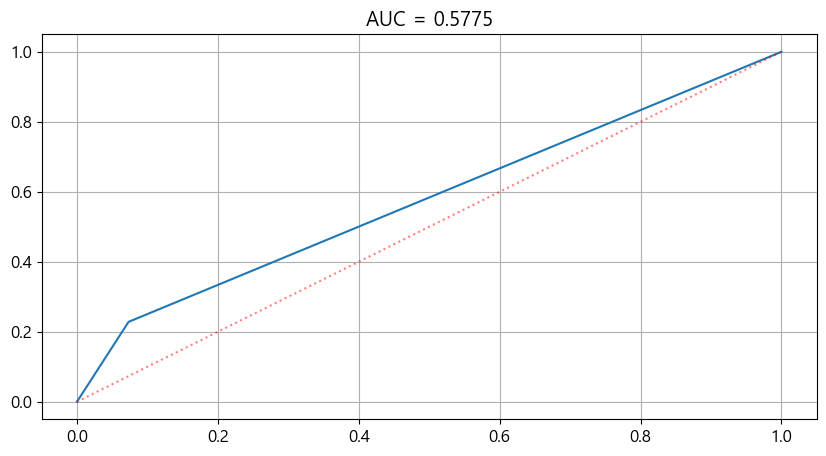

In [9]:
ras = roc_auc_score(df1['합격여부'], df1['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(df1['합격여부'], df1['예측결과'])

plt.figure()
sb.lineplot(x = fpr, y = tpr)
sb.lineplot(x = [0,1], y = [0,1], color = 'red', linestyle = ':', alpha = 0.5)
plt.title('AUC = {:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [10]:
# 정확도
acc = accuracy_score(df1['합격여부'], df1['예측결과'])

# 정밀도
pre = precision_score(df1['합격여부'], df1['예측결과'])

# 재현율
recall = recall_score(df1['합격여부'], df1['예측결과'])

# F1 score
f1 = f1_score(df1['합격여부'], df1['예측결과'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)': [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

result_df.T            

,0
설명력(Pseudo-Rsqe),0.081073
정확도(Accuracy),0.705000
정밀도(Precision),0.591837
"재현율(Recall, TPR)",0.228346
"위양성율(Fallout, FPR)",0.073260
"특이성(Specificity, TNR)",0.926740
RAS,0.577543
f1_score,0.329545


### 오즈비(Odds Rate) 구하기

#### 계수값들만 추출하기

- 독립변수의 `coef` : logit함수 계수. 해당 독립함수의 오즈에 $log$를 씌운 값 (자연로그)

In [11]:
coef = fit.params
coef

Intercept   -3.449549
필기점수         0.002294
학부성적         0.777014
병원경력        -0.560031
dtype: float64

#### 오즈비 계산

  - 오즈비는 성공할 확률을 실패할 확률로 나눈 값이고 이 분석에서는 합격여부가 종속변수이므로 합결할 확률을 불합격할 확률로 나눈 값이다.

$\text{Odds Rate} = \frac{합격확률}{불합격확률}$

계수값에 대해 `np.exp()` 함수를 적용하면 각각의 회귀계수들을 오즈값으로 변환할 수 있다.

> 해당 독립변수가 종속변수에 미치는 영향을 더 직관적으로 확인할 수 있다. 학부성적이 종속변수인 합격여부에 끼치는 영향이 가장 크다고 볼 수 있다.

In [12]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns= ['odds_rate'])
odds_rate_df

,odds_rate
Intercept,0.031760
필기점수,1.002297
학부성적,2.174967
병원경력,0.571191


#### 가상의 데이터를 통한 합격 여부 예측

In [13]:
myinput = input("필기점수, 학부성적, 병원경력을 콤마(,)로 구분하여 입력하세요.")

if not myinput:
    myinput = '480,4.3,2'

myinput = myinput.split(',')
mydata = {'필기점수': int(myinput[0].strip()), '학부성적': float(myinput[1].strip()), '병원경력': int(myinput[2].strip())}
myresult = fit.predict(mydata)
myresult

0    0.089757
dtype: float64

In [14]:
"당신의 합격 확률은 {0:0.2f}% 입니다.".format(myresult[0]*100)

'당신의 합격 확률은 8.98% 입니다.'

이후 진행할 과정

- 로지스틱 회귀 모듈화
- 데이터 표준화 적용 후 결과 비교
- 병원경력에 대해 더미변수 처리 후 표준화를 적용하지 않고 결과 비교
- 병원경력에 대해 더미변수 처리 후 표준화를 적용한 상태로 결과 비교